Здравствуйте, сделал задачу переноса стиля основываясь на вашем ноутбуке, в примере ниже загружаю 3 фотографии стиля,, ниже поянсю почему)

In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
!wg get

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
!ls content/drive/My\ Drive/images/

ls: cannot access 'content/drive/My Drive/images/': No such file or directory


**Загрузка изображений**

Решил показать, преобразование замка в стиле пикассо

In [0]:
h,w = 600,800

loader = transforms.Compose([
    transforms.Resize((h,w)),  # нормируем размер изображения
    transforms.CenterCrop((h,w)),
    transforms.ToTensor()])  # превращаем в удобный формат

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img2 = image_loader("/content/man.jpg").to(device)
style_img = image_loader('/content/пикасоо дама.webp').to(device)# as well as here
style_img3 = image_loader('/content/пикасо 1941.jpg').to(device)# as well as here
 
content_img1= image_loader("/content/еще замок.jpg").to(device)
device 

device(type='cuda')

Вывел только первые две.

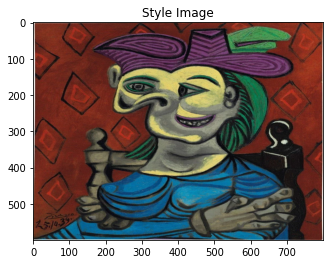

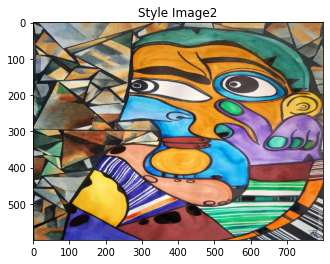

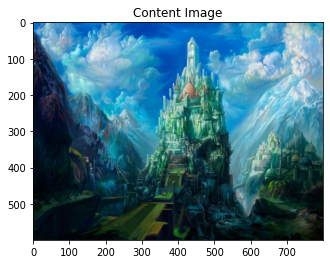

In [55]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img1, title='Content Image')

Дальше пока без изменения - создание классов ошибок и нормализации, тут все понятно

In [0]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [57]:
t = ContentLoss(style_img)
t.loss

tensor(0., device='cuda:0')

In [0]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [0]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим предобученную модель

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [0]:
for i in cnn.children():
  print(i)

In [0]:
def get_style_model_and_losses(
                                   cnn, normalization_mean, normalization_std,
                                   style_imgs, content_img,
                                   content_layers=content_layers_default,
                                   style=[style_layers_default ,style_layers_default2 ]
                               ):
        cnn = copy.deepcopy(cnn).to(device)
        
        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)
        
        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []
        style_losses2 = []
        for i in style:
          style_losses2.append([])
        
        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization).to(device)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target).to(device)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
            for v in range(len(style)):
              if name in style[v]:
                  # add style loss:
                  target_feature = model(style_imgs[v]).detach()
                  style_loss = StyleLoss(target_feature).to(device)
                  model.add_module("style_loss{}_{}".format(v,i), style_loss)
                  style_losses2[v].append(style_loss)
            
          

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]
        print(len(style_losses2))
        return model, style_losses2, content_losses

In [0]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        return optimizer

Дальше стандартный цикл обучения

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_imgs, input_img, num_steps=1000,
                        style_weights=[100000,100000],style=style, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_imgs,
             content_img, style=style)
        optimizer = get_input_optimizer(input_img)
        
        images=[]
        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img).to(device)

                style_score = []
                for i in range(len(style_losses)):
                  style_score.append(0)
                content_score = 0
                
                for t in range(len(style_losses)):
                  
                  for sl in style_losses[t]:
                      style_score[t] += sl.loss
                  
                for cl in content_losses:
                    content_score += cl.loss
                
                
                #взвешивание ощибки
                for i in range(len(style_score)):
                  style_score[i] *= style_weights[i]
                  
                content_score *= content_weight
                
                loss = 0
                for gg in style_score:
                  
                  loss +=  gg
                loss +=content_score
                loss.backward()
                
                run[0] += 1
                if run[0] % 60 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f} Style Loss2: {:4f}'.format(
                        style_score[0], content_score,style_score[1]))
                    
                    plt.figure(figsize=(2,2))
                    imshow(input_img, title='Output Image')
                    images.append(unloader(input_img.cpu().clone().squeeze(0)  ).copy())
                    torch.cuda.empty_cache()
                new_score = 0
                  
                return style_score[0] + content_score + style_score[1]

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img,images

In [0]:
d = []
for i in range(5):
  d.append(0)

In [0]:
torch.cuda.empty_cache()
input_img = content_img1.clone().to(device)

## Очень важное дополнение!!! Добавил возможность для n - го количества переносов стилей, то есть на одну картинку можно перенести сразу несколько других стилей, и все будет выполнятся не последовательно, а одновременно. Может показаться, что 2 картинки и так лишку, куда там три и более. НО НЕТ!!! Эксперименты показали, что большое количество картинок качественнее переносит стиль, что и логично. Так, лучше использовать несколько картин одного стиля или художника для улучшения переноса стиля. Можно видеть на примере замка. Кроме того добавил вывод картинок, чтобы видеть как все менялось. Я поставил себе задачу именно обобщения всех действий, так как эта задача полезнее и необходимей. КРоме того каждую картинку можно считать со своим весом учитывать, у каждой своя функция потерб, чтобы в будущем, при добавлении новых возможность в классы ошибок, можно было рассматривать для каждой картики отдельно. Получается намного интереснее при переносе 3 и более стилей на 1 картинку)

In [0]:
input_img = content_img1.clone().to(device)

setting = {'cnn':cnn,'cnn_normalization_mean':cnn_normalization_mean,
           'cnn_normalization_std':cnn_normalization_std,
           'content_img1':content_img1,
           'style_imgs':[style_img,style_img2,style_img3],
           'input':input_img,
           'epoches':400,
           'style_weights':[100000,100000,100000],
           
           'style_layers':[['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'],
                           ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5','conv_6'],
                           ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5','conv_6']],
           'content_weight':1}

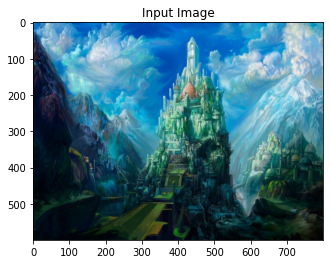

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


3
Optimizing..
run [60]:
Style Loss : 132.575714 Content Loss: 15.125955 Style Loss2: 975.948364


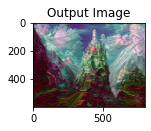

run [120]:
Style Loss : 120.435249 Content Loss: 14.388885 Style Loss2: 940.087646


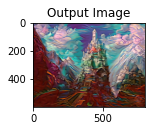

run [180]:
Style Loss : 116.505692 Content Loss: 13.214446 Style Loss2: 940.013611


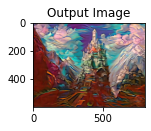

run [240]:
Style Loss : 114.226830 Content Loss: 12.238213 Style Loss2: 941.964233


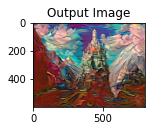

run [300]:
Style Loss : 113.763710 Content Loss: 11.526345 Style Loss2: 939.061707


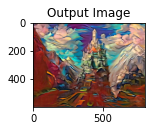

run [360]:
Style Loss : 113.454063 Content Loss: 11.052101 Style Loss2: 940.100769


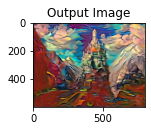

run [420]:
Style Loss : 113.072586 Content Loss: 10.688110 Style Loss2: 940.158020


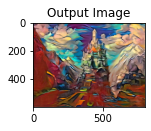

In [71]:

#для изменения работы сети достаточно изменить словарь ниже,
# у меня это заняло достаточно времени(добавить произвольное количество стилей)
# теперь работаю над созданием класса NST
plt.figure()
imshow(input_img, title='Input Image')
output,images= run_style_transfer(setting['cnn'], 
                                  setting['cnn_normalization_mean'],
                                  setting['cnn_normalization_std'],
                                  setting['content_img1'], 
                                  setting['style_imgs'], 
                                  setting['input'],
                                  setting['epoches'],
                                  setting['style_weights'],
                                  setting['style_layers'],
                                  setting['content_weight']
                                  )

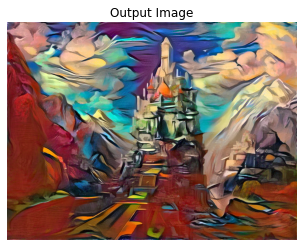

In [72]:
plt.figure()
plt.axis("off")
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()

plt.show()


In [0]:

def imshow1(tensor, title=None, name='ll',figsize=(10,10)):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    fig,axes = plt.subplots(figsize=figsize)
    axes.axis("off")
    axes.imshow(image)
    plt.ioff()
    fig.savefig(name)
 

In [0]:

imshow1(images[2], title='Output Image',name = 'замок_gog',figsize=(10,10))
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4


In [0]:
fig, axes =  plt.subplots(ncols = 1,nrows = len(images), figsize = (10,20))
for i in range(len(images)):
  
  
  axes[i].imshow(images[i])
fig.savefig('gg')


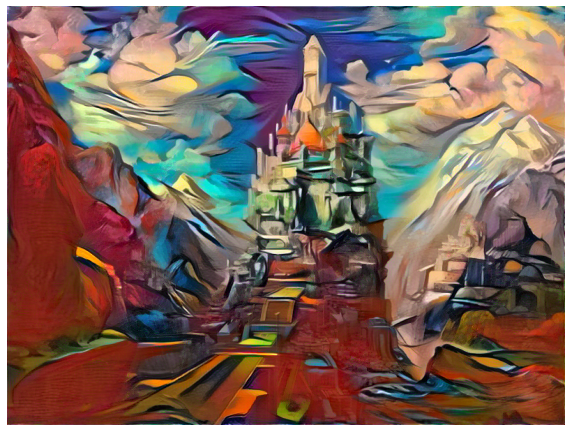

In [75]:
fig,axes = plt.subplots(figsize=(10,10))
axes.axis('off')
imshow(output)
fig.savefig('дворец пикассо')

Пикассо бы прослезился, особенно радует белая гора(на зажнем фоне с тенью в левой части) и облака

Хочу сказать спасибо за такое задание, так как приобрел отличный опыт и научился много новому(в частности совместной работе ) узнал новое, как из интеренета так и от товарещей и книг, которые кидали в канле. Было интересно!!!

In [0]:
fig,axes = plt.subplots(figsize=(10,10))
axes.axis('off')
imshow(output)
fig.savefig('Странник')

In [0]:
style_imgz = image_loader('/content/Tree (1).png').to(device)
style_imgz2 = image_loader('/content/fun_skelet.png').to(device)
style_imgz3 = image_loader('/content/leo_gog.png').to(device)
style_imgz4 = image_loader('/content/Странник.png').to(device)
style_imgz5 = image_loader('/content/кожажева.jpg').to(device)
style_imgz6 = image_loader('/content/новый лед.png').to(device)

yy = [style_imgz,style_imgz2,style_imgz3
      ,style_imgz4,style_imgz5,style_imgz6
      ]

Вот самые забавные и интересные опыты

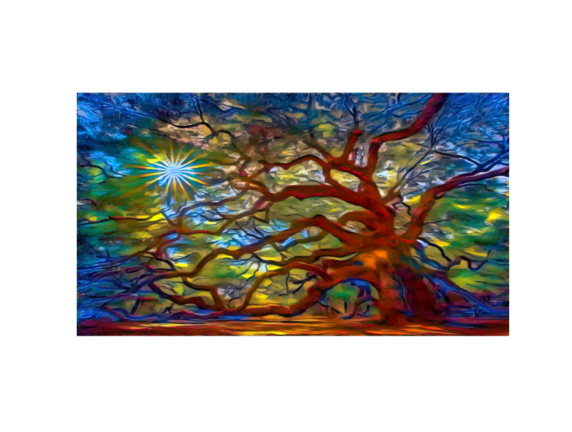

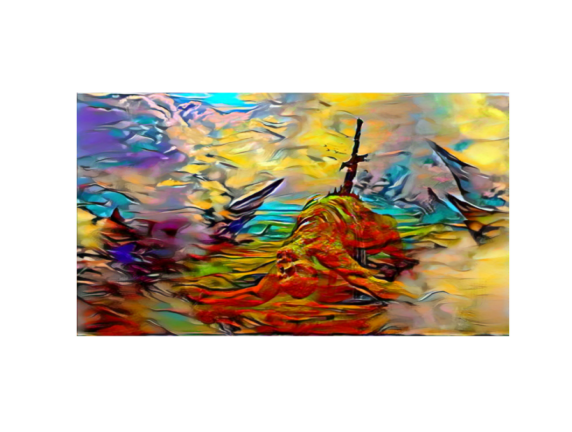

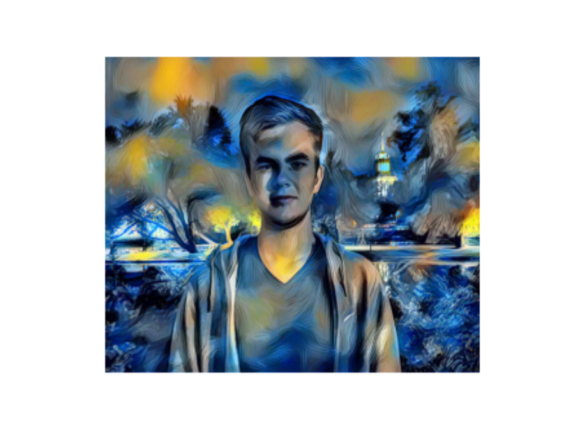

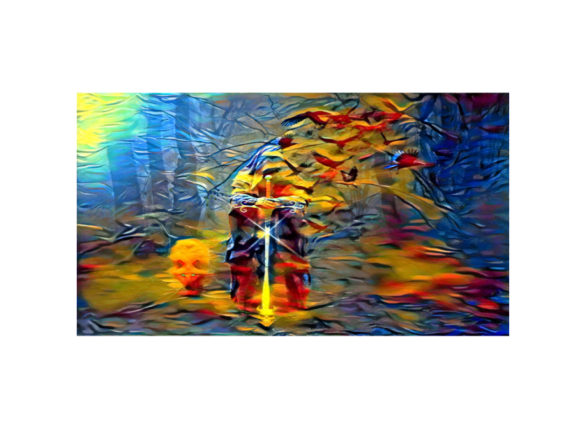

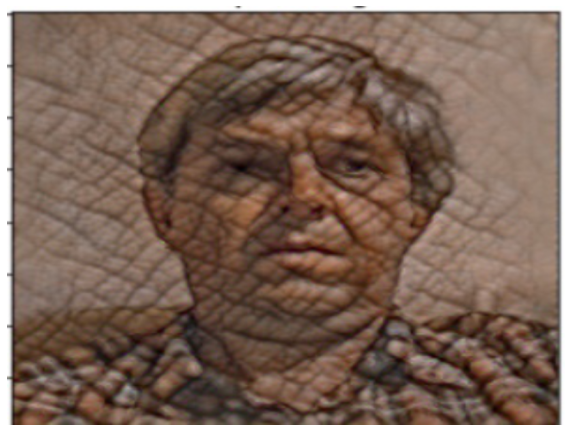

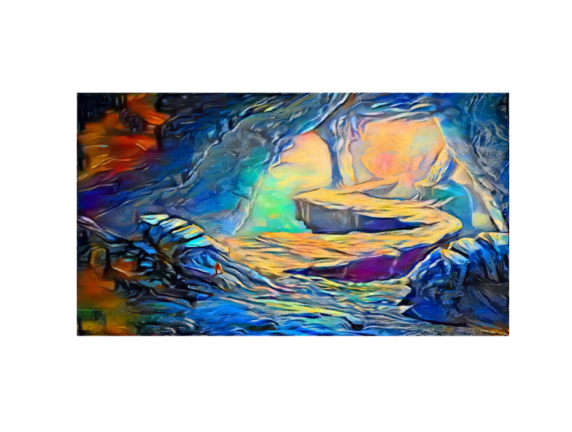

In [83]:
for t in yy:
  fig,axes = plt.subplots(figsize=(10,10))
  axes.axis('off')
  imshow(t)